In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os
from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
import skimage as sk
from scipy import misc

import cv2
from pylab import *
import torch
import torchvision
from torch import nn
from pathlib import Path
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import models
from torch import optim
from torch.utils.data import Dataset, DataLoader

import lovasz_losses as L

from tqdm import tqdm_notebook as tqdm

In [2]:
train_path = "/home/kaichou/ssd/salts/train"

In [3]:
train_df = pd.read_csv("/home/kaichou/ssd/salts/train.csv", index_col="id", usecols=[0])
depth_df = pd.read_csv("/home/kaichou/ssd/salts/depths.csv", index_col="id")
train_df = train_df.join(depth_df)
test_df = depth_df[~depth_df.index.isin(train_df.index)]

In [4]:
train_df["images"] = [plt.imread(os.path.join(train_path, f"images/{idx}.png")) for idx in tqdm(train_df.index)]

In [5]:
train_df["masks"] = [plt.imread(os.path.join(train_path, f"masks/{idx}.png")) for idx in tqdm(train_df.index)]

In [6]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return sk.transform.resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return sk.transform.resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [8]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [9]:
train_df.shape[0]

4000

Text(0.5,0,'Coverage class')

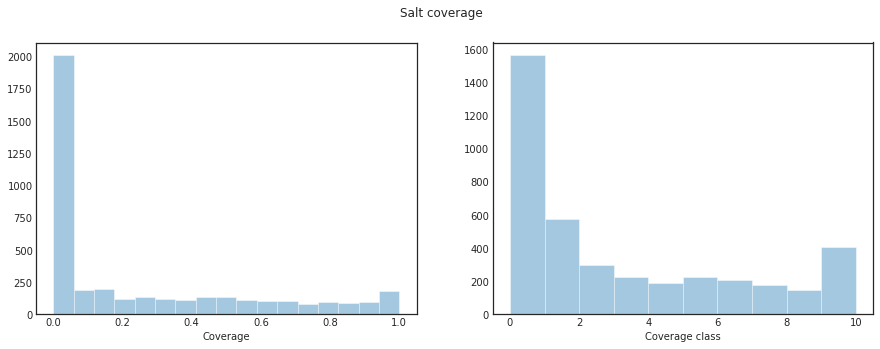

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

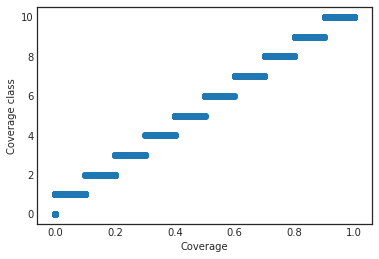

In [11]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

Text(0.5,1,'Depth distribution')

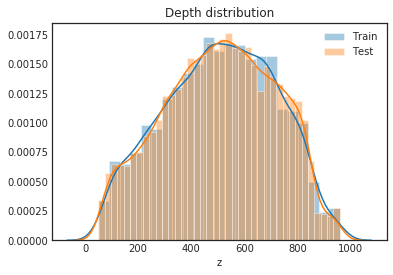

In [12]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

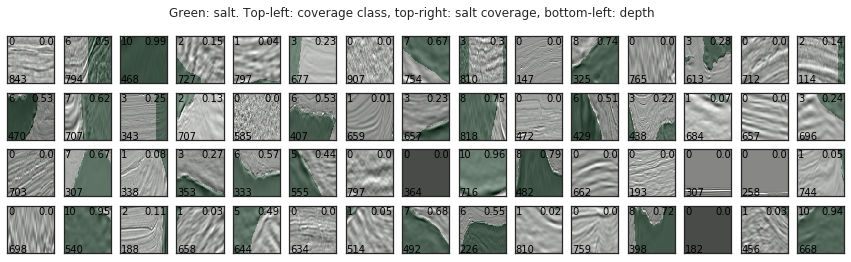

In [13]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [14]:
train_df.index

Index(['575d24d81d', 'a266a2a9df', '75efad62c1', '34e51dba6a', '4875705fb0',
       '782ae9b7e7', '9842f69f8d', 'aa94cfb806', '50d3073821', '28f865caaa',
       ...
       '633c7d5c80', '30082e87d9', 'f139be21a4', 'ac931ace49', 'cb36193e2f',
       '9cbd5ddba4', 'caa039b231', '1306fcee4c', '48d81e93d9', 'edf1e6ac00'],
      dtype='object', name='id', length=4000)

In [15]:
(sum(train_df["masks"]['575d24d81d']) <20) & (sum(train_df["masks"]['575d24d81d']) != 0)

False

In [16]:
for i in train_df.index:
    if (sum(train_df["masks"][i]) < 20) & (sum(train_df["masks"][i]) != 0):
        train_df = train_df.drop(i, axis=0)

In [17]:
for i in train_df.index:
    if (sum(train_df["masks"][i]) < 20) & (sum(train_df["masks"][i]) != 0):
        print(i)

In [18]:

print(train_df.images.shape)


(3931,)


In [19]:
np.shape(upsample(train_df.images[0]))

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(128, 128, 3)

In [20]:
np.shape(np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3))

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(3931, 128, 128, 3)

In [21]:
np.shape(np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1))

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(3931, 128, 128, 1)

In [22]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 3), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 1234)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [30]:
del(x_train, x_valid, y_train, y_valid)

In [31]:
del(train_df)

In [33]:
import gc
gc.collect()

40

In [24]:
torch.cuda.is_available()

True

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x




class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class AlbuNet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder

        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)

        return x_out
    
def albunet(pretrained = False, **kwargs):

    model = AlbuNet(pretrained = pretrained)

    return model


In [27]:
def get_model():
    model = albunet(pretrained=True)
    model.train()
    return model.to(device)

In [28]:
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

In [29]:
def chw_to_hwc(img):
    return np.transpose(img, axes=[1, 2, 0])

In [35]:
class SaltsDataset(Dataset):
    
    def __init__(self, ids):
        
        self.len = len(ids)
        self.list_IDs = ids
        

    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        
        ID = self.list_IDs[index]
        
        x = plt.imread(f"/home/kaichou/ssd/salts/train/images/{ID}.png")
        x = upsample(x)
        x = torch.from_numpy(x)
        x = hwc_to_chw(x.float())
        
        y = plt.imread(f"/home/kaichou/ssd/salts/train/masks/{ID}.png")
        y = upsample(y)
        y = torch.from_numpy(y)
        y = hwc_to_chw(y.float())
        return x, y
        

In [36]:
train_dataset = SaltsDataset(ids_train, x_train, y_train, device)
valid_dataset = SaltsDataset(ids_valid, x_valid, y_valid, device)

In [8]:
model = get_model()
model = model.cuda()

In [38]:
def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / union
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou

In [39]:
train_dataset.len

3144

In [40]:
from torch.autograd import Function, Variable

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 0.0001
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union + self.inter) \
                         / self.union * self.union
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return s / (i + 1)

In [41]:
def jaccard(y_true, y_pred):
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1)
    union = y_true.sum(dim=-2).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1)

    return ((intersection + epsilon)/ (union - intersection + epsilon)).mean()

In [42]:
def eval_net(net, dataset, N_valid):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    tot = 0
    for x, y in dataset:
        x = x.cuda()
        y = y.cuda()

        mask_pred = net(x)
        mask_pred = (F.sigmoid(mask_pred) > 0.5).float()

        tot += jaccard(mask_pred.cpu(), y.cpu())
    return tot / N_valid

In [49]:
def train_model(net, train_dataset, valid_dataset, 
                epochs=200, batch_size=32, lr=0.001, save_cp=True, opti = "adam"):
    if opti == "adam":
        optimizer = optim.Adam(net.pparameters(), lr=lr, weight_decay=0.0005)
    elif opti == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        
    dir_checkpoint = 'checkpoints/'
    criterion = nn.BCELoss()
        
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
    N_train = train_dataset.len
    N_valid = valid_dataset.len
    for epoch in tqdm(range(epochs)):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            mask_pred = net(x)
            mask_probs = F.sigmoid(mask_pred)
            mask_probs_flat = mask_probs.view(-1)
                
            true_mask_flat = y.view(-1)
                    
            loss = criterion(mask_probs_flat, true_mask_flat)
                
            epoch_loss += loss.item()
                
            print('{0:.4f} --- loss: {1:.6f}'.format(batch_size / N_train, loss.cpu().item()))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / N_train))
            
        if 1:
            val_dice = eval_net(net, valid_loader, N_valid)
            print('Validation IoU Coeff: {}'.format(val_dice))
    
        if epoch % 50 == 0:
            torch.save(net.state_dict(),
                        dir_checkpoint + 'CP1{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))

In [50]:
def train_model_lovasz(net, train_dataset, valid_dataset, 
                epochs=200, batch_size=32, lr=0.001, save_cp=True, opti = "adam"):
    if opti == "adam":
        optimizer = optim.Adam(net.pparameters(), lr=lr, weight_decay=0.0005)
    elif opti == "sgd":
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        
    dir_checkpoint = 'checkpoints_lovasz/'
        
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
    valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
    N_train = train_dataset.len
    N_valid = valid_dataset.len
    for epoch in tqdm(range(epochs)):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
        net.train()
        epoch_loss = 0
        for x, y in train_loader:
            x = x.cuda()
            y = y.cuda()
            mask_pred = net(x)
            mask_probs = F.sigmoid(mask_pred)
            mask_probs_flat = mask_probs.view(-1)
                
            true_mask_flat = y.view(-1)
                    
            loss = L.lovasz_hinge_flat(mask_probs_flat, true_mask_flat)
                
            epoch_loss += loss.item()
                
            print('{0:.4f} --- loss: {1:.6f}'.format(batch_size / N_train, loss.cpu().item()))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / N_train))
            
        if 1:
            val_dice = eval_net(net, valid_loader, N_valid)
            print('Validation IoU Coeff: {}'.format(val_dice))
    
        if epoch % 50 == 0:
            torch.save(net.state_dict(),
                        dir_checkpoint + 'CP1{}.pth'.format(epoch + 1))
            print('Checkpoint {} saved !'.format(epoch + 1))

In [ ]:
train_model(model, train_dataset=train_dataset, valid_dataset=valid_dataset)

In [ ]:
train_model_lovasz(model, train_dataset=train_dataset, valid_dataset=valid_dataset, epochs=100)

In [9]:
test_path = "/home/kaichou/ssd/salts/test"

In [10]:
test_df = pd.read_csv("/home/kaichou/ssd/salts/sample_submission.csv", index_col="id", usecols=[0])

In [11]:
test_df.head()

""
id
155410d6fa
78b32781d1
63db2a476a
17bfcdb967
7ea0fd3c88


In [12]:
ids_test = test_df.index.values

In [13]:
class SaltsTestDataset(Dataset):
    
    def __init__(self, ids):
        
        self.len = len(ids)
        self.list_IDs = ids
        
    def __len__(self):
        return self.len
        
    def __getitem__(self, index):
        
        ID = self.list_IDs[index]
        
        x = plt.imread(f"/home/kaichou/ssd/salts/test/images/{ID}.png")
        x = upsample(x)
        x = torch.from_numpy(x)
        x = hwc_to_chw(x.float())
        return x
        

In [14]:
test_dataset = SaltsTestDataset(ids_test)

In [23]:
test_masks = []

In [24]:
test_masks

[]

In [25]:
def test_work(net, dataset, batch_size = 32):
    net.eval()
    test_loader = DataLoader(dataset = dataset, batch_size = batch_size)
    for x in tqdm(test_loader):
        x = x.float().cuda()
        mask = net(x)
        for i in mask.cpu():
            test_masks.append(i.detach().numpy())

In [26]:
test_work(model, test_dataset)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [143]:
shit = np.copy(test_masks[0])

In [27]:
test_masks[0]

array([[[  1.8021765,   3.1466746,   4.154047 , ...,   4.665279 ,
           3.5969388,   2.100752 ],
        [  3.1461272,   5.709131 ,   7.532638 , ...,   8.347527 ,
           6.37977  ,   3.5990655],
        [  4.1558723,   7.534231 ,   9.863028 , ...,  10.780669 ,
           8.222933 ,   4.6255636],
        ...,
        [  3.3736713,   6.319199 ,   8.517401 , ..., -20.736889 ,
         -16.236225 ,  -9.147669 ],
        [  2.2574651,   4.189902 ,   5.694455 , ..., -16.130594 ,
         -12.6103735,  -7.081083 ],
        [  1.1690143,   2.0693724,   2.7836144, ...,  -8.999647 ,
          -7.015957 ,  -3.9065733]]], dtype=float32)

In [28]:
test_df["masks"] = test_masks.copy()

In [29]:
test_df.masks = test_df.masks.apply(chw_to_hwc)

In [30]:
test_df.masks = test_df.masks.apply(downsample)

/home/kaichou/.virtualenvs/virtual-py3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [31]:
np.shape(test_df["masks"][0])

(101, 101, 1)

In [32]:
test_df["masks"][0]

array([[[  2.1832933 ],
        [  3.93687044],
        [  5.12013085],
        ...,
        [  5.72207014],
        [  4.44550184],
        [  2.52395614]],

       [[  3.93730586],
        [  7.25343332],
        [  9.39085957],
        ...,
        [ 10.36640372],
        [  8.00277553],
        [  4.42613075]],

       [[  5.11997238],
        [  9.39947449],
        [ 12.10879493],
        ...,
        [ 13.14719646],
        [ 10.15845528],
        [  5.60475076]],

       ...,

       [[  4.43659591],
        [  8.40474892],
        [ 10.74870537],
        ...,
        [-24.47599741],
        [-19.62927843],
        [-10.99025569]],

       [[  3.01764808],
        [  5.75857377],
        [  7.54503402],
        ...,
        [-19.520563  ],
        [-15.6335262 ],
        [ -8.73239999]],

       [[  1.45328423],
        [  2.68157234],
        [  3.48166637],
        ...,
        [-10.8217195 ],
        [ -8.64152007],
        [ -4.78973341]]])

In [145]:
shit = chw_to_hwc(shit)

In [146]:
shit

array([[[  1.8021765],
        [  3.1466746],
        [  4.154047 ],
        ...,
        [  4.665279 ],
        [  3.5969388],
        [  2.100752 ]],

       [[  3.1461272],
        [  5.709131 ],
        [  7.532638 ],
        ...,
        [  8.347527 ],
        [  6.37977  ],
        [  3.5990655]],

       [[  4.1558723],
        [  7.534231 ],
        [  9.863028 ],
        ...,
        [ 10.780669 ],
        [  8.222933 ],
        [  4.6255636]],

       ...,

       [[  3.3736713],
        [  6.319199 ],
        [  8.517401 ],
        ...,
        [-20.736889 ],
        [-16.236225 ],
        [ -9.147669 ]],

       [[  2.2574651],
        [  4.189902 ],
        [  5.694455 ],
        ...,
        [-16.130594 ],
        [-12.6103735],
        [ -7.081083 ]],

       [[  1.1690143],
        [  2.0693724],
        [  2.7836144],
        ...,
        [ -8.999647 ],
        [ -7.015957 ],
        [ -3.9065733]]], dtype=float32)

In [147]:
shit[shit > 0.5] = 1
shit[shit <= 0.5] = 0


In [141]:
sum(shit.nonzero())

481395

In [41]:
for i in test_df["masks"]:
    #i[i > 0.5] = 1
    #i[i <= 0.5] = 0
    i[i == 1] = 2
    i[i == 0] = 1
    i[i == 2] = 0

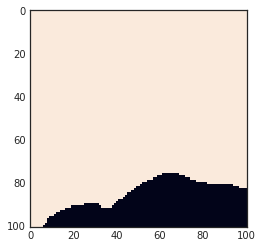

In [42]:
plt.imshow(np.squeeze(test_df["masks"][0] ))

In [43]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [44]:
rle_coded = [rle_encode(x) for x in test_df["masks"]]

In [45]:
test_df["rle_mask"] = rle_coded

In [46]:
test_df.head()

,masks,rle_mask
id,,
155410d6fa,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...",1 706 708 99 809 97 910 96 1011 96 1112 95 121...
78b32781d1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",58 44 158 45 259 45 359 46 458 48 558 49 658 5...
63db2a476a,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",6760 7 6858 11 6957 13 7055 16 7154 18 7252 21...
17bfcdb967,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",4274 5 4357 5 4368 25 4401 3 4423 7 4435 9 445...
7ea0fd3c88,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",


In [47]:
submission = test_df.drop(columns="masks")

In [48]:
submission.to_csv("submission.csv")

In [20]:
checkpoint = torch.load("./checkpoints_lovasz/CP151.pth")

In [21]:
model.load_state_dict(checkpoint)

In [101]:
!mkdir checkpoints_lovasz

In [66]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

In [37]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)

NameError: name 'batch_size' is not defined

In [57]:
batch_size = 32
lr=0.001

In [73]:
loss = nn.BCELoss()

trainer = create_supervised_trainer(model,optimizer, loss)
evaluator = create_supervised_evaluator(model,
                                        metrics={
                                            'accuracy': CategoricalAccuracy(),
                                            'nll': Loss(loss)
                                        })

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(trainer):
    print("Epoch[{}] Loss: {:.2f}".format(trainer.state.epoch, trainer.state.output))

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['nll']))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(valid_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['accuracy'], metrics['nll']))

trainer.run(train_loader, max_epochs=200)